Changes:
* Changes, max ?n batches. Stop at 5% accuracy.
* Components count twice for wire length calculation.
* There was an issue where circuit was not connected, but was still accepted. To fix this, Logic gates are know only accepted, if both inputs and the output are used, otherwise replaced by wire.

Things to do:
* Time each operation. | Actually, wait with this until later. It should be in the report, but if the code is subject to change, the timing may also change and need to be redone.
* Evaluate how many of the new circuits are acctually being added to the dataset
* Evaluate how many of the new circuits are shorter than the existing ones.
* Track how the amount of different errors change with the size of the dataset.
* Make a thing for continuously running the bootstrapping.


Things to write about:
* With the rate at which circuits are being discovered, how long would it take to make a proper dataset?


_____
For training, train ever 5120 synthetic data. Also ever bootstrapping iterations should live update exmaples of circuits.

Graphs of logged data should also be available. Maybe save and overwrite?


In [1]:
import torch
import torch.nn as nn
from CircuitSimulation.CircuitSimulator import *
import numpy as np
from diffusers import UNet2DConditionModel
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap
import hashlib
from itertools import combinations
from tqdm import tqdm
import random
from collections import defaultdict
import os
import pickle

In [2]:
# Initial circuits

InitialCicuits = torch.tensor([
    [
        [1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 3, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 3, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
    ],
])

InitialTables = torch.tensor([
    [
        [0, 0, 2, 2, 0, 2, 2, 2 ],
        [1, 0, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 0, 2, 2, 2 ],
        [1, 1, 2, 2, 1, 2, 2, 2 ],
    ],
    [
        [0, 0, 2, 2, 2, 0, 2, 2 ],
        [1, 0, 2, 2, 2, 0, 2, 2 ],
        [0, 1, 2, 2, 2, 0, 2, 2 ],
        [1, 1, 2, 2, 2, 1, 2, 2 ],
    ],
    [
        [0, 0, 2, 2, 2, 2, 0, 2 ],
        [1, 0, 2, 2, 2, 2, 0, 2 ],
        [0, 1, 2, 2, 2, 2, 0, 2 ],
        [1, 1, 2, 2, 2, 2, 1, 2 ],
    ],
    [
        [0, 0, 2, 2, 2, 2, 2, 0 ],
        [1, 0, 2, 2, 2, 2, 2, 0 ],
        [0, 1, 2, 2, 2, 2, 2, 0 ],
        [1, 1, 2, 2, 2, 2, 2, 1 ],
    ],
])

In [3]:
# Transform initial data into data for neural network model
# Also has a few utility functions for data manipulation and visualization

def imageToProbabilities(image, numCategories):
    # The categorical scheduler expects each channel to describe the probability of a pixel being of that class
    # Therefore, a RawCircuit, with one channel, needs to be expanded to have numCategories channels

    bs, h, w = image.shape
    
    imageProbabilites = torch.zeros(bs, numCategories, h, w)
    for b in range(bs):
        for i in range(h):
            for j in range(w):
                pixelClass = image[b, i, j]
                imageProbabilites[b, pixelClass, i, j] = 1.0

    return imageProbabilites

def tablePadding(truthTable):
    #Takes a truthtable and adds rows to fix row amount to 16.
    rows = truthTable.shape[0]

    padding = torch.full((16 - rows, truthTable.shape[1]), 2.0)
    return torch.cat((truthTable, padding), dim=0).long()

def countWires(circuit):
    sum = 0
    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if circuit[i][j] >= 1:
                sum += min(2, circuit[i][j])
    return sum

def printCircuit(circuit):
    cmap = ListedColormap(['white', 'black', 'red', 'blue'])
    fig, ax = plt.subplots(figsize=(2, 2))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(circuit, cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    plt.tight_layout()
    plt.show()

# Function to get the hash of a tensor
def get_tensor_hash(tensor):
    # Flatten the tensor and convert to tuple (hashable)
    tensor_tuple = tuple(tensor.flatten().tolist())
    
    # Compute the hash using hashlib (SHA-256)
    hash_object = hashlib.sha256(str(tensor_tuple).encode())
    return hash_object.hexdigest()

# lists to dictionary
def CreateTrainingDictionary(inpDict, rawCircuits, tables):
    with torch.no_grad():
        shorterCircuits = 0
        for table, circuit in zip(tables, rawCircuits):
            truth = tablePadding(table)
            key = truth.numpy().tobytes() #Hashable
            wiresTotal = countWires(circuit)
            
            if key not in inpDict:
                inpDict[key] = (imageToProbabilities(circuit.unsqueeze(0), 4).squeeze(), wiresTotal)
            else: 
                oldCircuit, wireAmount = inpDict[key]
                if wireAmount > wiresTotal: # If new has less wires
                    inpDict[key] = (imageToProbabilities(circuit.unsqueeze(0), 4).squeeze(), wiresTotal)
                    shorterCircuits += 1

        return inpDict, shorterCircuits

class CircuitDataset(Dataset):
    def __init__(self, inpDict):
        self.dict = inpDict
        self.keys = list(self.dict.keys())

        self.hashes = [get_tensor_hash(torch.argmax(circuit, dim=0, keepdim=True))
                       for circuit, _ in list(inpDict.values())]

    def __len__(self):
        return len(self.dict)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        circuit, wireAmount = self.dict[key]
        
        return circuit, torch.from_numpy(np.frombuffer(key)).long().reshape(16, 8)

# Mostly a copy of CircuitDataset, but with the item count inflated, to match previous tests.
class LoopingDataset(Dataset):
    def __init__(self, inpDict):
        self.dict = inpDict
        self.keys = list(self.dict.keys())

        self.hashes = [get_tensor_hash(torch.argmax(circuit, dim=0, keepdim=True))
                       for circuit, _ in list(inpDict.values())]
    def __len__(self):
        normalLen = len(self.dict) # Is 4
        return normalLen * 4 # previous tests had 16 
    
    def __getitem__(self, idx):
        key = self.keys[idx % len(self.dict)]
        circuit, wireAmount = self.dict[key]
        
        return circuit, torch.from_numpy(np.frombuffer(key)).long().reshape(16, 8)


trainingDict, _ = CreateTrainingDictionary({}, InitialCicuits, InitialTables)
dataset = LoopingDataset(trainingDict)

loader = DataLoader(dataset, batch_size=64, shuffle=True)

print("dataset generated as 'loader")

dataset generated as 'loader


In [4]:
# Set truthtable embedder

class RowEmbedder(nn.Module):
    def __init__(self, num_categories, vector_length, embedding_dim):
        super().__init__()
        self.shared_embed = nn.Embedding(num_categories, embedding_dim)
        self.position_weights = nn.Parameter(torch.ones(vector_length, embedding_dim))
        self.position_bias = nn.Parameter(torch.zeros(vector_length, embedding_dim))
        
    def forward(self, x):
        # x shape: [batch_size, vector_length]
        shared = self.shared_embed(x)  # [batch_size, vector_length, emb_dim]
        # Apply position-specific scaling and shifting
        return shared * self.position_weights + self.position_bias
    

class TabularTransformer(nn.Module):
    def __init__(self, num_categories, num_features, d_model):
        super().__init__()
        self.d_model = d_model

        self.row_embedding = RowEmbedder(num_categories, num_features, d_model) #num_categories, vector_length, embedding_dim

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model * num_features,
            nhead=8,
            dim_feedforward=2*d_model * num_features,
            batch_first=True,
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=6,
        )
    
    def forward(self, x):
        #batch_size, num_rows, num_cols = x.shape

        rows = self.row_embedding(x) #bs, rows, columns, embedding
        #rows = rows.mean(dim=2)
        rows = rows.flatten(start_dim=2) 
        
    
        transformed = self.transformer(rows)

        return transformed

transformer = TabularTransformer(3, 8, 16)

print("embedder created as transformer")
print(f"Embedded shape: {transformer(InitialTables)[0].shape}")

embedder created as transformer
Embedded shape: torch.Size([4, 128])


In [5]:
# Set up scheduler

class CategoricalScheduler:
    def __init__(self, TrainSteps = 200, numCategories = 4, betaStart = 0.0001, betaEnd = 0.02):
        self.TrainSteps = TrainSteps
        self.noiseDevice = 'cpu'
        self.numCategories = numCategories

        self.betas = torch.linspace(betaStart, betaEnd, TrainSteps, device=self.noiseDevice)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def addNoise(self, imageBatch, time):
        bs, ch, w, h = imageBatch.shape

        with torch.no_grad():
            alpha_t = self.alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

            # the per pixel probability distribution of the categories
            currentProbabilities = imageBatch

            # The chance of each state per pixel when noised            
            updatedProbabilities = currentProbabilities * alpha_t + (1 - alpha_t) / self.numCategories 
            updatedProbabilities = updatedProbabilities.permute(0, 2, 3, 1) # reshape such that it is flattened correctly below
            updatedProbabilities = updatedProbabilities.reshape(bs*w*h, self.numCategories)  
            

            # 1 Sample per value
            categoricalNoise = torch.multinomial(updatedProbabilities, 1, replacement=True)
            categoricalNoise = categoricalNoise.view(bs, w, h) # Shape: [bs, w, h]

            noisedImages = F.one_hot(categoricalNoise, num_classes=self.numCategories)
            noisedImages = noisedImages.permute(0, 3, 1, 2) # [bs, num_classes, w, h]

            return noisedImages

scheduler = CategoricalScheduler()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [6]:
# Create Diffuser

class CategoricalDiffusionModel(nn.Module):
    def __init__(self, imageSize, numCategories, embeddingSize, attentionHeads=8, guidanceProb=0.1):
        super().__init__()
        self.guidance_prob=guidanceProb
        self.model = UNet2DConditionModel(
            sample_size=imageSize, 
            in_channels=numCategories,  # Image channels
            out_channels=numCategories,
            cross_attention_dim=embeddingSize,  # Matches mbedding's token dim 
            attention_head_dim=attentionHeads,     # Smaller head dim for efficiency
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(128, 128, 128), 
            down_block_types=(
                "CrossAttnDownBlock2D",  
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
            ),
        )
        
    def forward(self, x, t, embedding):
        bs, ch, w, h = x.shape

        #Use guidance probability, to help the model learn that 'circuit behvaior' 
        # is a general feature and not specific to a particular embedding.
        if self.training:
            mask = torch.rand_like(embedding, device=x.device) < self.guidance_prob
            embedding[mask] = 0

        return self.model(x, t, encoder_hidden_states=embedding).sample

In [7]:
# Training Function

def trainCatModel(catModel, dataloader, embeddingModel, losses, stopAccuracy = 0.05, batchLimit = 100, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

    if PLOTUPDATES:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(catModel.parameters(), lr=1e-4) 


    batchNum = 0
    isTraining = True
    while isTraining:
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = catModel(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

            if PLOTUPDATES:
                if len(losses) % updateRate == 0:
                    clear_output(wait=True)  
                    ax.clear()
                    plt.plot(losses)
                    plt.xlabel('Batch')
                    display(fig)
                    
            batchNum += 1
            if loss < stopAccuracy:
                    isTraining = False
                    break
            elif batchNum >= batchLimit:
                isTraining = False
                break
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

In [8]:
# Sockets used for simulating
inpSockets = [
    (Socket("inp0", True), (-1, 0)), 
    (Socket("inp1", True), (-1, 4)), 
    (Socket("inp2", True), (-1, 8)), 
    (Socket("inp3", True), (-1, 12)), 
]

outSockets = [  
    (Socket("out0", False), (13, 0)), 
    (Socket("out1", False), (13, 4)), 
    (Socket("out2", False), (13, 8)), 
    (Socket("out3", False), (13, 12)),
]   

In [9]:
# Why pre and after pruning?
# Pruning unconnected wires won't make simulation faster, as they aren't even used in the connection or socket maps.
# So the idea was to only prune these things before adding them to the dataset.
# However, when checking if the generated circuit already exists, it helps also removing those wires
# So both pre and after pruning are used before simulating, yet the functions are kept separate, as is.


# Prunes inputs, outputs and wireSets that have only have components recieving or emitting signals.
# Wiresets with no components connected are never added to the connectionMap, so they are not pruned here, -
# These wiresets have no influence on the circuit's behavior (or simulation speed), -
# so pruning them can wait till after the circuit has been confirmed to be useful
def prePruning(connectionMap, socketMap):
    prunedConnections = []
    for connection in connectionMap:
        relevantConnection = any(
            component.isSource for component in connectionMap[connection]
        ) and any(
            not component.isSource for component in connectionMap[connection]
        )
        
        if not relevantConnection:
            prunedConnections.append(connection)

    for connection in prunedConnections:
        del connectionMap[connection]  

    connectedInputs = []
    connectedOutputs = []
    for socket, connections in socketMap.items():
        for connection in list(connections):
            if connection in prunedConnections:
                socketMap[socket].remove(connection)
                
        prefix, compid, comptype = socket.name
        
        if prefix == "inp" and bool(socketMap[socket]):
            connectedInputs.append(int(compid))
        elif prefix == "out" and bool(socketMap[socket]):
            connectedOutputs.append(int(compid))
    
    return connectedInputs, connectedOutputs


# Of the connected inputs, get combinations for a truthtable. for example socket [[], [0], [1], [0,1]]
def generateSocketCombinations(inputSockets, relevantIndexes):
    #inputSockets = All available input sockets
    #relevantIndexes = the indexes of sockets that are connected to components
    
    usedSockets = [inputSockets[i][0] for i in relevantIndexes]
    
    # Generate all combinations (power set)
    orderList = []
    for r in range(len(usedSockets) + 1):
        for combo in combinations(usedSockets, r):
            orderList.append(list(combo))
    
    return orderList

In [10]:
# After pruning

# Things to prune:
# Unconncted wires
# wires from prepruning

def afterPruning(circuit, wiresets, connectionMap):
    # Prunes wires, from pruned connections
    # And replaces gates that aren't connected on all inputs and outputs with a wire.
    circuitWasUpdated = False

    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if wiresets[i][j] not in connectionMap and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitWasUpdated = True

            elif circuit[i][j] > 1: # If gate
                #Check if it should be replaced with a wire

                try:
                    if (circuit[i][j + 1] == 0 or # If emmitter is 0
                        circuit[i][j - 1] == 0): # If base is 0

                        circuit[i][j] = 1 
                        circuitWasUpdated = True
                except: #
                    circuit[i][j] = 1 
                    circuitWasUpdated = True

                if (
                    (i < circuit.shape[1] - 1 and circuit[i + 1][j] == 0) 
                    and
                    (i - 1 < 0 and circuit[i - 1][j] == 0)):
                    circuit[i][j] = 1 
                    circuitWasUpdated = True                

    #Because there gate positions aren't stored, socket map will have to be recreated, but then connetionmap will also need to be updated.
    return circuit, connectionMap, circuitWasUpdated

# Prunes excess wires from the circuit.
def pruneExcessWires(circuit):
    circuitDirty = False
    
    for j in range(1, circuit.shape[0] - 1):
        for i in range(circuit.shape[1]):
            center = circuit[i][j]
            up     = circuit[i - 1][j] if i > 0 else 0
            down   = circuit[i + 1][j] if i < circuit.shape[0] - 1 else 0
            left   = circuit[i][j - 1] 
            right  = circuit[i][j + 1] 

            crossValue = center + up + down + left + right

            if crossValue < 3 and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitDirty = True
    
    if circuitDirty:
        return pruneExcessWires(circuit)
    else: return circuit

def hasWireSquare(circuit):
    #Just disallow these.
    rows = circuit.shape[0]
    cols = circuit.shape[1]

    for i in range(rows - 1):
        for j in range(cols - 1):
            if (circuit[i][j] == 1 and
                circuit[i][j + 1] == 1 and
                circuit[i + 1][j] == 1 and
                circuit[i + 1][j + 1] == 1):
                return True
    return False

In [11]:
def GetTruthTable(inputIndexes, outputIndexes, socketMap, connectionMap, orders):
    # Orders is a list of the order in which input sockets are activated.
    # # Truthtables usually do not make use of activation order, but the simulation needs it.

    truthTable = torch.ones(size=(2**len(inputIndexes), 8)) * 2

    row = 0
    #try
    for order in orders:
        for socket in socketMap.keys():
            socket.state = False
        
        # Gives the state of sockets at the end. But only output sockets are relevant, 
        # and those are available through outSockets[i][0]
        _ = Simulate(connectionMap, socketMap, order) 

        for index in inputIndexes:
            truthTable[row][index] = 0

        for socket in order:
            prefix, idnum, comptype = socket.name
            truthTable[row][int(idnum)] = 1

        for i in outputIndexes:
            truthTable[row][i + 4] = outSockets[i][0].state

        row += 1

    return truthTable

In [ ]:
# Generate N Circuits
def GenerateN(model, amount = 100):
    model.eval()
    
    ## GENERATE CIRCUITS
    with torch.no_grad():
        batchX = torch.randint(size=(amount, 13, 13), high = 4, low = 0, device=device )
        batchX = imageToProbabilities(batchX, 4)

        batchY = torch.randint(size=(amount, 16, 8), high = 2, low = 0, device='cpu' )
        batchY = transformer(batchY).to(device)
        
        # Inference with trainingsteps // 64 + 1, for faster generations. Even with this few steps, generations become perfect after training, due to small dataset.
        stepDivisor = 64
        inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps // stepDivisor, device='cpu').long()

        for t in inferenceSteps:
            residual_cond = model(batchX.to(device).float(), t, batchY.float()) 
            residual = F.softmax(residual_cond, dim=1)
            batchX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
        batchX = F.softmax(model(batchX.to(device), 0, batchY), dim=1)

        # Get circuit values
        argmaxedBatch = torch.argmax(batchX, dim=1, keepdim=True).cpu().numpy().squeeze()

        return argmaxedBatch
    

def requireGate(circuit):
    rows = circuit.shape[0]
    cols = circuit.shape[1]

    for i in range(rows):
        for j in range(cols):
            if circuit[i][j] > 1:
                return True
    return False

def getTables(circuits):
    #Prunes
    #Checks hashes
    #Simulates
    #Then, generates tables
    with torch.no_grad():
        tables = []
        simulatedCircuits = []
        simulatedCircuitHashes = []

        unique_hashes = {}
        circuitsErrors = defaultdict(int)
        for i in range((circuits.shape[0])):
            circuitDirty = True # Pruning flag

            while circuitDirty:
                socketMap, wireSets = GetSocketMap(circuits[i], inpSockets + outSockets)
                connectionMap = GetConnectionMap(socketMap)


                inps, outs = prePruning(connectionMap, socketMap)
                circuit, connectionMap, circuitDirty = afterPruning(circuits[i], wireSets, connectionMap)
                circuit = pruneExcessWires(circuit)

            if hasWireSquare(circuit):
                circuitsErrors["Has Square"] += 1
                continue
            
            hash = get_tensor_hash(circuit)
            if hash not in unique_hashes:
                if hash not in dataset.hashes:

                    #Get orderlist
                    if len(inps) > 1 and len(outs) > 0: # Bias to have only circuits with at least 2 inputs
                        orderlist = generateSocketCombinations(inpSockets, inps)

                        try:    
                            if requireGate(circuit):
                                truthTable = GetTruthTable(inps, outs, socketMap, connectionMap, orderlist)
                                tables.append(truthTable)
                                simulatedCircuits.append(circuit)
                                simulatedCircuitHashes.append(hash)
                                unique_hashes[hash] = i
                            else:
                                circuitsErrors["No gates"] += 1        

                        except Exception as e:
                            circuitsErrors[str(e)] += 1
                    else:
                        circuitsErrors["Not Sufficiently Connected"] += 1
                else:
                    circuitsErrors["Duplicate"] += 1
            else:
                circuitsErrors["New Duplicate"] += 1
                
        return tables, simulatedCircuits, simulatedCircuitHashes, circuitsErrors

In [13]:
# GenerateN and getTables combined.

def GenerateAndSimulate(model, amount = 100):    
    argmaxCircuits = GenerateN(model, amount)

    tables, simulatedCircuits, simulatedCircuitsHashes, errors = getTables(argmaxCircuits)

    return tables, simulatedCircuits, simulatedCircuitsHashes, errors

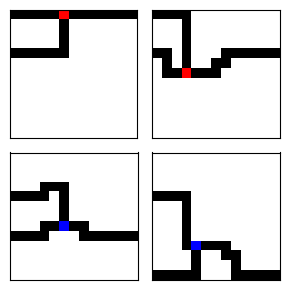

In [14]:
# Show dataset circuits

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(2, 2, figsize=(3, 3))
for idx, ax in enumerate(axes.flat):
    ax.imshow(InitialCicuits[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [15]:
def SampleCircuits(model, iterations = 10, samples = 512):
    newCircuits = []
    newCircuitHashes = []
    newTables = []

    errors = defaultdict(int)
    for i in range(iterations):
        t, a, h, e = GenerateAndSimulate(model, amount=samples)
        for circuit, hash, table in zip(a, h, t):
            if hash not in newCircuitHashes:
                newCircuitHashes.append(hash)   
                newCircuits.append(circuit)
                newTables.append(table)

        for error, count in e.items():
            errors[error] += count

    return newCircuits, newTables, errors

In [18]:
def plot_25(item): # Returns the fig instead of displaying it
    cmap = ListedColormap(['white', 'black', 'red', 'blue'])
    cols = 5
    rows = min(len(item) + 4, 25) // cols
    if rows == 0:
        return

    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx >= len(item):
            continue
        ax.imshow(item[idx], cmap=cmap, vmin=0, vmax=3)
    plt.tight_layout()
    return fig



def save_progress(model, circuitErrors, trainingDict, trainingDictSize, dataIncrease, amountShorter, amountCircuitsGenerated, path='checkpoint'):
    os.makedirs(path, exist_ok=True)

    # Save model
    torch.save(model.state_dict(), os.path.join(path, 'model_01-05-2025.pt'))

    # Save other data
    save_data = {
        'circuitErrors': circuitErrors,
        'trainingDict': trainingDict,
        'trainingDictSize': trainingDictSize,
        'dataIncrease': dataIncrease,
        'amountCircuitsGenerated': amountCircuitsGenerated,
        'amountShorter': amountShorter
    }

    with open(os.path.join(path, 'training_data_01-05-2025.pkl'), 'wb') as f:
        pickle.dump(save_data, f)




def Bootstrap(epochs, model, loss, trainingDict): #Make error dict?
    dataset = CircuitDataset(trainingDict)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    errorClasses = ["Has Square", "No gates", "Not Sufficiently Connected", "Duplicate", "New Duplicate"]
    circuitErrors = {error: [] for error in errorClasses}

    trainingDictSize = [len(trainingDict)]
    dataIncrease = []
    amountCircuitsGenerated = []
    amountShorter = []

    for epoch in tqdm(range(epochs)):
        #Train model
        model, loss = trainCatModel(model, loader, transformer, loss, PLOTUPDATES=False)

        # Generate new data
        newCircuits, newTables, errors = SampleCircuits(model, samples=256)
        for error in errorClasses:
            circuitErrors[error].append(errors[error])
        amountCircuitsGenerated.append(len(newCircuits))
            
        # Update training dictionary
        pastLen = len(trainingDict)
        trainingDict, fasterCircuits = CreateTrainingDictionary(trainingDict, torch.tensor(newCircuits), newTables)
        dataset = CircuitDataset(trainingDict)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)
        dataIncrease.append(len(trainingDict) - pastLen)
        trainingDictSize.append(len(trainingDict))
        amountShorter.append(fasterCircuits)

        # Save progress
        save_progress(model, circuitErrors, trainingDict, trainingDictSize, dataIncrease, amountShorter, amountCircuitsGenerated)


        # Draw updates
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

        axes[0].plot(trainingDictSize)
        axes[0].set_title('Size of trainingDict')

        for label, values in circuitErrors.items():
            axes[1].plot(values, label=label)
        axes[1].plot(dataIncrease, label="Samples added to training data")
        axes[1].plot(amountCircuitsGenerated, label="Succesful Samples")
        axes[1].plot(amountShorter, label="Shorter Samples")
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Circuit errors over time')
        axes[1].legend()

        axes[2].plot(loss)
        axes[2].set_xlabel('Batch')
        axes[2].set_title('Loss') # This should add lines or something to show whenever retraining happens

        fig2 = plot_25(newCircuits)

        display(fig)
        plt.close(fig)
        display(fig2)
        plt.close(fig2)

    return model, loss, trainingDict

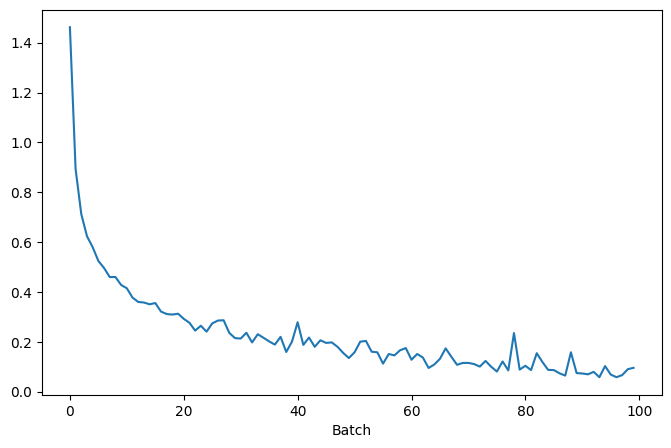

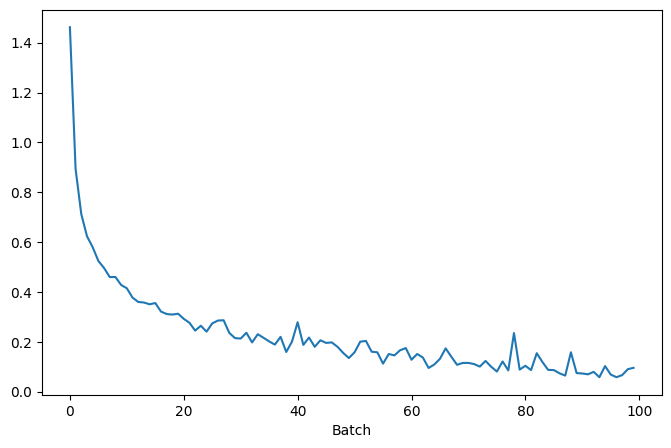

In [17]:
# Warmup model
model = CategoricalDiffusionModel(13, 4, 128).to(device)
model, loss = trainCatModel(model, loader, transformer, [])

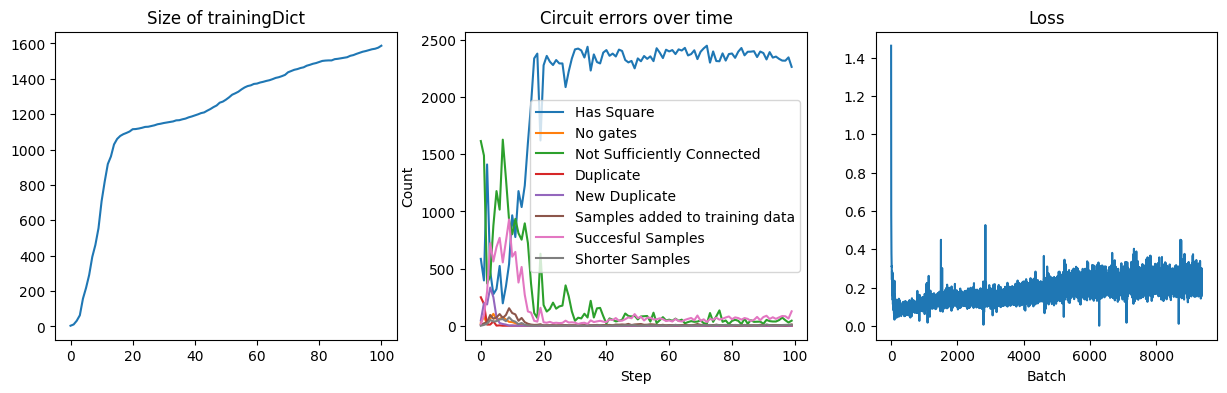

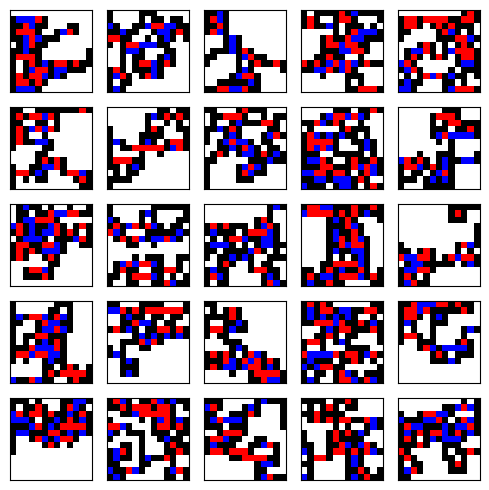

100%|██████████| 100/100 [2:05:15<00:00, 75.15s/it] 


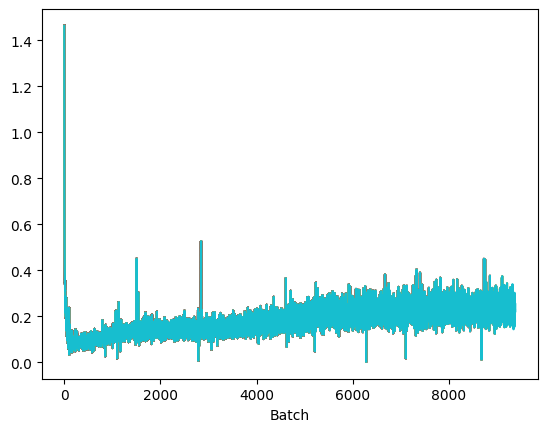

In [19]:
model, loss, trainingDict = Bootstrap(100, model, loss,trainingDict)

In [22]:
def load_checkpoint(checkpoint_path='checkpoint'):
    # Load training data
    with open(os.path.join(checkpoint_path, 'training_data_01-05-2025.pkl'), 'rb') as f:
        data = pickle.load(f)

    print(data.keys())

    # Unpack data
    circuitErrors = data['circuitErrors']
    trainingDict = data['trainingDict']
    trainingDictSize = data['trainingDictSize']
    dataIncrease = data['dataIncrease']
    amountCircuitsGenerated = data['amountCircuitsGenerated']
    amuntShorter = data['amountShorter']
    #amountShorter

    return circuitErrors, trainingDict, trainingDictSize, dataIncrease, amountCircuitsGenerated, amuntShorter

ce, td, tds, di, acg, ams = load_checkpoint()

dict_keys(['circuitErrors', 'trainingDict', 'trainingDictSize', 'dataIncrease', 'amountCircuitsGenerated', 'amountShorter'])


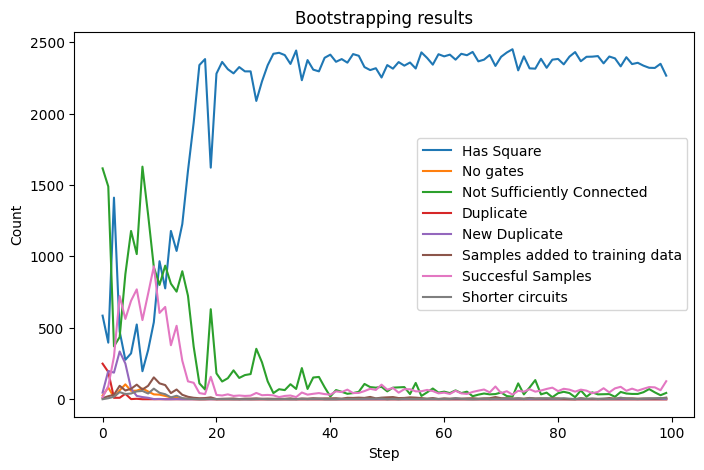

In [27]:
fig = plt.figure(figsize=(8, 5))


plot1List = []#['Has Square', 'Not Sufficiently Connected']

for label, values in ce.items():
    if label not in plot1List:
        plt.plot(values, label=label)
plt.plot(di, label="Samples added to training data")
plt.plot(acg, label="Succesful Samples")
plt.plot(ams, label="Shorter circuits")

plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Bootstrapping results')
plt.legend()

plt.show()

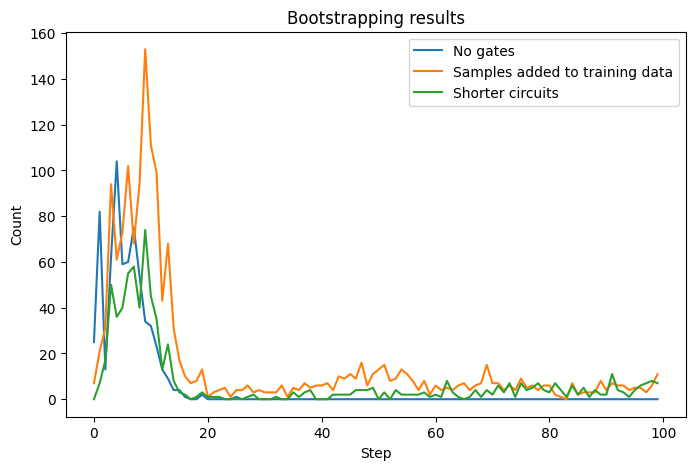

In [29]:
fig = plt.figure(figsize=(8, 5))


plot1List = ['Has Square', 'Not Sufficiently Connected', 'New Duplicate', 'Duplicate']

for label, values in ce.items():
    if label not in plot1List:
        plt.plot(values, label=label)
plt.plot(di, label="Samples added to training data")
#plt.plot(acg, label="Succesful Samples")
plt.plot(ams, label="Shorter circuits")

plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Bootstrapping results')
plt.legend()

plt.show()

______________

In [30]:
dataset = CircuitDataset(trainingDict)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
print(len(trainingDict))

1587


In [31]:
gatePositions = set()
for batch, label in loader:
    circuits = torch.argmax(batch, dim=1, keepdim=True).cpu().numpy().squeeze()
    for circuit in circuits:
        #print(circuit.shape)
        for i in range(circuit.shape[0]):
            for j in range(circuit.shape[1]):
                if circuit[i][j] > 1:
                    gatePositions.add((circuit[i][j].item(), i, j))


print(gatePositions)

{(2, 8, 3), (2, 11, 8), (2, 0, 8), (3, 7, 6), (2, 12, 0), (2, 12, 9), (2, 4, 5), (3, 11, 3), (3, 0, 3), (2, 7, 6), (3, 3, 4), (2, 8, 7), (2, 0, 3), (2, 11, 3), (3, 7, 1), (3, 7, 10), (2, 12, 4), (2, 4, 0), (2, 4, 9), (2, 7, 1), (2, 7, 10), (3, 3, 8), (2, 8, 2), (2, 8, 11), (2, 0, 7), (2, 11, 7), (3, 7, 5), (3, 10, 7), (3, 2, 3), (2, 3, 8), (2, 7, 5), (3, 3, 3), (3, 6, 5), (3, 9, 10), (2, 0, 2), (2, 11, 2), (3, 10, 2), (3, 10, 11), (3, 2, 7), (2, 3, 3), (2, 7, 0), (2, 7, 9), (3, 6, 0), (3, 6, 9), (3, 9, 5), (2, 10, 1), (2, 10, 10), (2, 2, 6), (3, 10, 6), (3, 2, 2), (3, 2, 11), (2, 3, 7), (2, 7, 4), (2, 6, 8), (3, 6, 4), (3, 9, 0), (3, 9, 9), (2, 10, 5), (2, 2, 1), (3, 10, 1), (2, 2, 10), (3, 10, 10), (3, 2, 6), (2, 3, 2), (2, 3, 11), (3, 5, 7), (2, 6, 3), (3, 6, 8), (3, 9, 4), (2, 10, 0), (2, 10, 9), (2, 2, 5), (3, 2, 1), (3, 1, 5), (3, 4, 10), (2, 9, 4), (3, 5, 2), (3, 5, 11), (2, 6, 7), (3, 6, 3), (3, 9, 8), (2, 10, 4), (2, 2, 0), (2, 2, 9), (3, 12, 0), (3, 1, 0), (2, 5, 11), (3, 12, 

In [32]:
ANDGATES = 0
NANDGATES = 0
for gate, x, y in gatePositions:
    if gate == 2:
        ANDGATES += 1
    elif gate == 3:
        NANDGATES += 1

print(f"ANDGATES: {ANDGATES}")
print(f"NANDGATES: {NANDGATES}")

ANDGATES: 156
NANDGATES: 156


In [165]:
#torch.save(trainingDict, "circuitDict.pt")